In [45]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm

In [46]:
pw = os.getcwd()
terminus_data_path = pw+"/../data/terminus_data/"        # folder where all the data for terminus position and terminus sections is stored
veloc_data_path    = pw+"/../data/velocity/"
weather_data_path  = pw+"/../data/weather/"
mooring_data_path  = pw+"/../data/mooring/GAK/"
seismic_data_path  = pw+"/../data/seismic/"

In [47]:
# load datasets
df_veloc      = pd.read_csv(veloc_data_path+"velocity_by_section.csv")
df_terminus   = pd.read_csv(terminus_data_path+"retreat_by_section.csv")
df_ablation   = pd.read_csv(terminus_data_path+"frontal_ablation.csv")
df_retr_rate  = pd.read_csv(terminus_data_path+"retreat_rate_by_section.csv")
df_weather    = pd.read_csv(weather_data_path+"compiled_weather_data_PDDs.csv")
df_mooring    = pd.read_csv(mooring_data_path+"GAK_smooth.csv")
df_seismic    = pd.read_csv(seismic_data_path+"hubval_gq_1988-2024.csv", names=['lat', 'long', 'depth', 'Date', 'evid', 'mi'], header=1)
# bring time vectors into right format
t                  = [dt.datetime.strptime(day, "%Y-%m-%d").date() for day in df_terminus.Date]
df_veloc.Date      = pd.to_datetime(df_veloc.Date)
df_terminus.Date   = pd.to_datetime(df_terminus.Date)
df_ablation.Date   = pd.to_datetime(df_ablation.Date)
df_retr_rate.Date   = pd.to_datetime(df_retr_rate.Date)
df_mooring.Date    = pd.to_datetime(df_mooring.Date)
df_weather.rename(columns={"Unnamed: 0":"Date"}, inplace=True)
df_weather.Date = pd.to_datetime(df_weather.Date)  # already has a sample each day
df_seismic.Date = pd.to_datetime(df_seismic.Date)


In [48]:
# resample/interpolate time series to daily values (so they can later be averaged over the year more easily) and average over section
df_veloc = df_veloc.resample("d", on="Date").mean().interpolate()
df_terminus = df_terminus.resample("d", on="Date").mean().interpolate()
df_ablation = df_ablation.resample("d", on="Date").mean().interpolate()
df_retr_rate = df_retr_rate.resample("d", on="Date").mean().interpolate()
df_mooring = df_mooring.resample("d", on="Date").mean().interpolate()
df_seismic = df_seismic.resample("d", on="Date").count()
df_weather.set_index("Date",inplace=True)

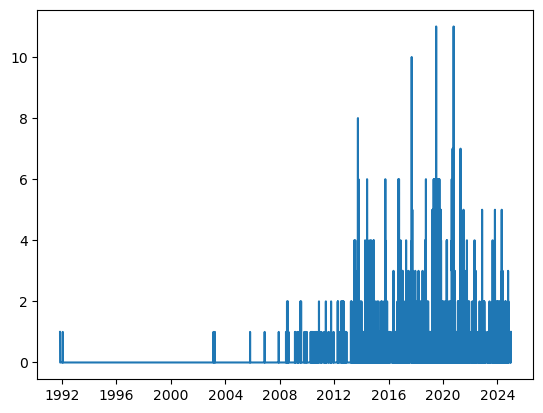

In [49]:
plt.plot(df_seismic.index, df_seismic.evid)

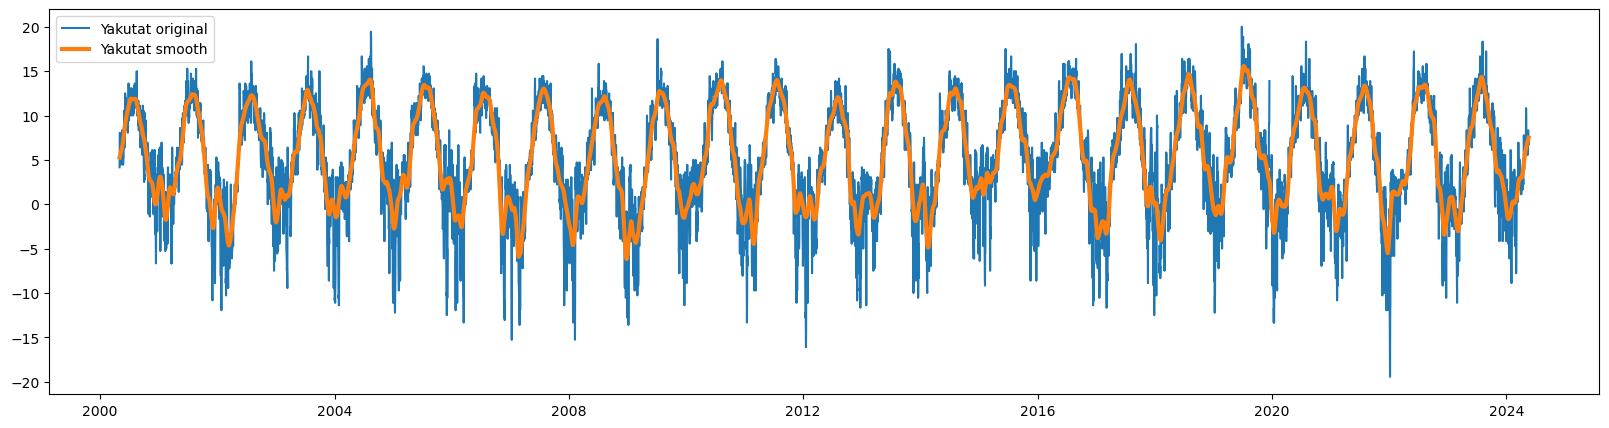

In [50]:
# use lowess filter to smooth temperatue time series, easier on day index rather than datetime format
t0 = pd.Timestamp(dt.datetime.strptime("2017-01-01", "%Y-%m-%d").date())
t_index_data   = np.zeros(len(df_weather.index), dtype=int)
# ddd = [dt.datetime.strptime(d, format).date() for d in df_avyr["Date"]]
for (i, da) in enumerate(df_weather.index):
    deltat = da - t0
    t_index_data[i] = deltat.days
lowess = sm.nonparametric.lowess

# df_smooth = pd.DataFrame({"Date" : df_all.Date})
z = lowess(df_weather["Yakutat_AirTemp_C"], t_index_data, frac=1/200, xvals=t_index_data)
df_weather["AirTempC_Yakutat_smooth"] = z
# z = lowess(df_weather["AirTempC_Haenke1"], t_index_data, frac=1/60, xvals=t_index_data)
# df_weather["AirTempC_Haenke1_smooth"] = z

plt.figure(figsize=(20,5))
plt.plot(df_weather.index, df_weather["Yakutat_AirTemp_C"], label="Yakutat original")
plt.plot(df_weather.index, df_weather["AirTempC_Yakutat_smooth"], lw=3, label="Yakutat smooth")
plt.legend()

# plt.figure(figsize=(20,5))
# plt.plot(df_weather.index, df_weather["AirTempC_Haenke1"])
# plt.plot(df_weather.index, df_weather["AirTempC_Haenke1_smooth"], lw=3)

In [51]:
# define function to cut all the time series to the minimal overlap
def equal_period(df_inputs):
    dstart = np.max([np.min(df.index) for df in df_inputs])
    dend   = np.min([np.max(df.index) for df in df_inputs])
    dfs = [df.iloc[np.where((df.index >= dstart) & (df.index <= dend))[0]] for df in df_inputs]
    return dfs

In [71]:
# combine all data together in one dataframe
df_mooring1, df_veloc1, df_terminus1, df_ablation1, df_retr_rate1, df_weather1, df_seismic1    = equal_period([df_mooring, df_veloc, df_terminus, df_ablation, df_retr_rate, df_weather, df_seismic])

assert len(df_mooring1) == len(df_veloc1) == len(df_terminus1) == len(df_weather1) == len(df_seismic1)

df_all  = pd.DataFrame()
for (df, nam) in zip([df_veloc1, df_terminus1, df_ablation1, df_retr_rate1, df_weather1, df_mooring1.iloc[:,0:4], df_seismic1], ["velocity", "terminus", "ablation", "retreat_rate", "", "", "seis_events"]):
    if df_all.empty:
        df_all["Date"] = pd.to_datetime(df.index)  # df.index
    if (nam == "velocity") or (nam == "terminus") or (nam == "ablation") or (nam == "retreat_rate"):
        df_all[nam] = df.mean(axis=1).values    
    else:
        df_all = df.merge(df_all, how="inner", on="Date")
df_save = df_all.rename(columns={"terminus":"terminus_advance_m", "velocity":"surface_speed_m_per_yr", "ablation":"frontal_ablation_m_per_yr", "retreat_rate":"retreat_rate_m_per_yr", "Temperature [deg C] @ 25m":"OceanTemp@25m_degC", "Temperature [deg C] @ 50m":"OceanTemp@50m_degC", "Temperature [deg C] @ 100m":"OceanTemp@100m_degC", "Yakutat_Precip_mm":"Precip_Yakutat_24h_mm"})
df_save.to_csv("terminus_speed_weather_ocean.csv", index=False)
df_all

,Date,lat,long,depth,evid,mi,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,...,Haenke_PDD,Yakutat_PDD,Water Year,Haenke_PDD_cumsum,Yakutat_PDD_cumsum,AirTempC_Yakutat_smooth,velocity,terminus,ablation,retreat_rate
0,2017-01-23,2,2,2,2,2,5.416903,5.883931,6.628854,6.034123,...,0.113587,2.222222,2017,372.913106,296.111111,-3.051537,2199.749740,357.220294,1863.516311,-240.967385
1,2017-01-24,0,0,0,0,0,5.388539,5.839919,6.587477,5.996998,...,0.674725,3.055556,2017,373.587831,299.166667,-2.964428,2208.419088,356.532690,1874.671018,-238.021979
2,2017-01-25,0,0,0,0,0,5.360578,5.795886,6.545444,5.959307,...,1.213736,4.444444,2017,374.801568,303.611111,-2.872570,2217.088435,355.845086,1885.825725,-235.076572
3,2017-01-26,0,0,0,0,0,5.333012,5.752157,6.502860,5.921233,...,3.184066,4.722222,2017,377.985634,308.333333,-2.782791,2225.757783,355.157482,1896.980431,-232.131166
4,2017-01-27,0,0,0,0,0,5.305841,5.709051,6.459867,5.882969,...,4.354348,3.611111,2017,382.339981,311.944444,-2.700305,2234.427131,354.469878,1908.135138,-229.185760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1200,2020-05-07,0,0,0,0,0,5.390310,4.851969,5.109256,5.167097,...,5.882812,9.722222,2020,482.171128,639.444444,7.350230,2244.458497,144.293002,2022.677809,-145.858774
1201,2020-05-08,0,0,0,0,0,5.431897,4.870253,5.126338,5.162342,...,6.864063,12.222222,2020,489.035191,651.666667,7.464198,2251.603423,143.806554,2026.032563,-149.993690
1202,2020-05-09,0,0,0,0,0,5.473854,4.888587,5.143451,5.157583,...,7.592708,14.444444,2020,496.627899,666.111111,7.575230,2258.748349,143.320106,2029.387318,-154.128606
1203,2020-05-10,0,0,0,0,0,5.516171,4.906971,5.160596,5.152821,...,8.235789,12.500000,2020,504.863689,678.611111,7.685401,2265.893275,142.833659,2032.742072,-158.263522


In [66]:
# combine all data together in one dataframe
# df_veloc1, df_terminus1, df_ablation1, df_retr_rate1, df_weather1    = equal_period([df_veloc, df_terminus, df_ablation, df_retr_rate, df_weather])

# assert len(df_veloc1) == len(df_terminus1) == len(df_weather1) == len(df_ablation1)

# df_all  = pd.DataFrame()
# for (df, nam) in zip([df_veloc1, df_terminus1, df_ablation1, df_retr_rate1, df_weather1], ["velocity", "terminus", "ablation", "retreat_rate", "", ""]):  # [df_veloc1, df_terminus1, df_ablation1, df_weather1]
#     if "Date" in df:
#             df.set_index("Date", inplace=True)
#     if df_all.empty:
#         df_all["Date"] = pd.to_datetime(df.index)  # df.index
#     if (nam == "velocity") or (nam == "terminus") or (nam == "ablation") or (nam == "retreat_rate"):
#         df_all[nam] = df.mean(axis=1).values
#         # print(len(df.mean(axis=1).values))
#     else:
#         df_all = df.merge(df_all, how="inner", on="Date")
# df_all
# df_save = df_all.rename(columns={"terminus":"terminus_retreat_m", "velocity":"surface_speed_m_per_yr", "ablation":"frontal_ablation_m_per_yr", "retreat_rate":"retreat_rate_m_per_yr"})
# df_save.to_csv("terminus_speed_weather.csv", index=False)
# df_save

In [72]:
print(df_save.columns)

Index(['Date', 'lat', 'long', 'depth', 'evid', 'mi', 'OceanTemp@25m_degC',
       'OceanTemp@50m_degC', 'OceanTemp@100m_degC',
       'Temperature [deg C] @ 150m', 'Haenke_AirTemp_C', 'Haenke_Precip_mm',
       'Precip_Yakutat_24h_mm', 'Yakutat_Snow_mm', 'Yakutat_SnowDepth_mm',
       'Yakutat_AirTemp_C', 'Haenke_PDD', 'Yakutat_PDD', 'Water Year',
       'Haenke_PDD_cumsum', 'Yakutat_PDD_cumsum', 'AirTempC_Yakutat_smooth',
       'surface_speed_m_per_yr', 'terminus_advance_m',
       'frontal_ablation_m_per_yr', 'retreat_rate_m_per_yr'],
      dtype='object')


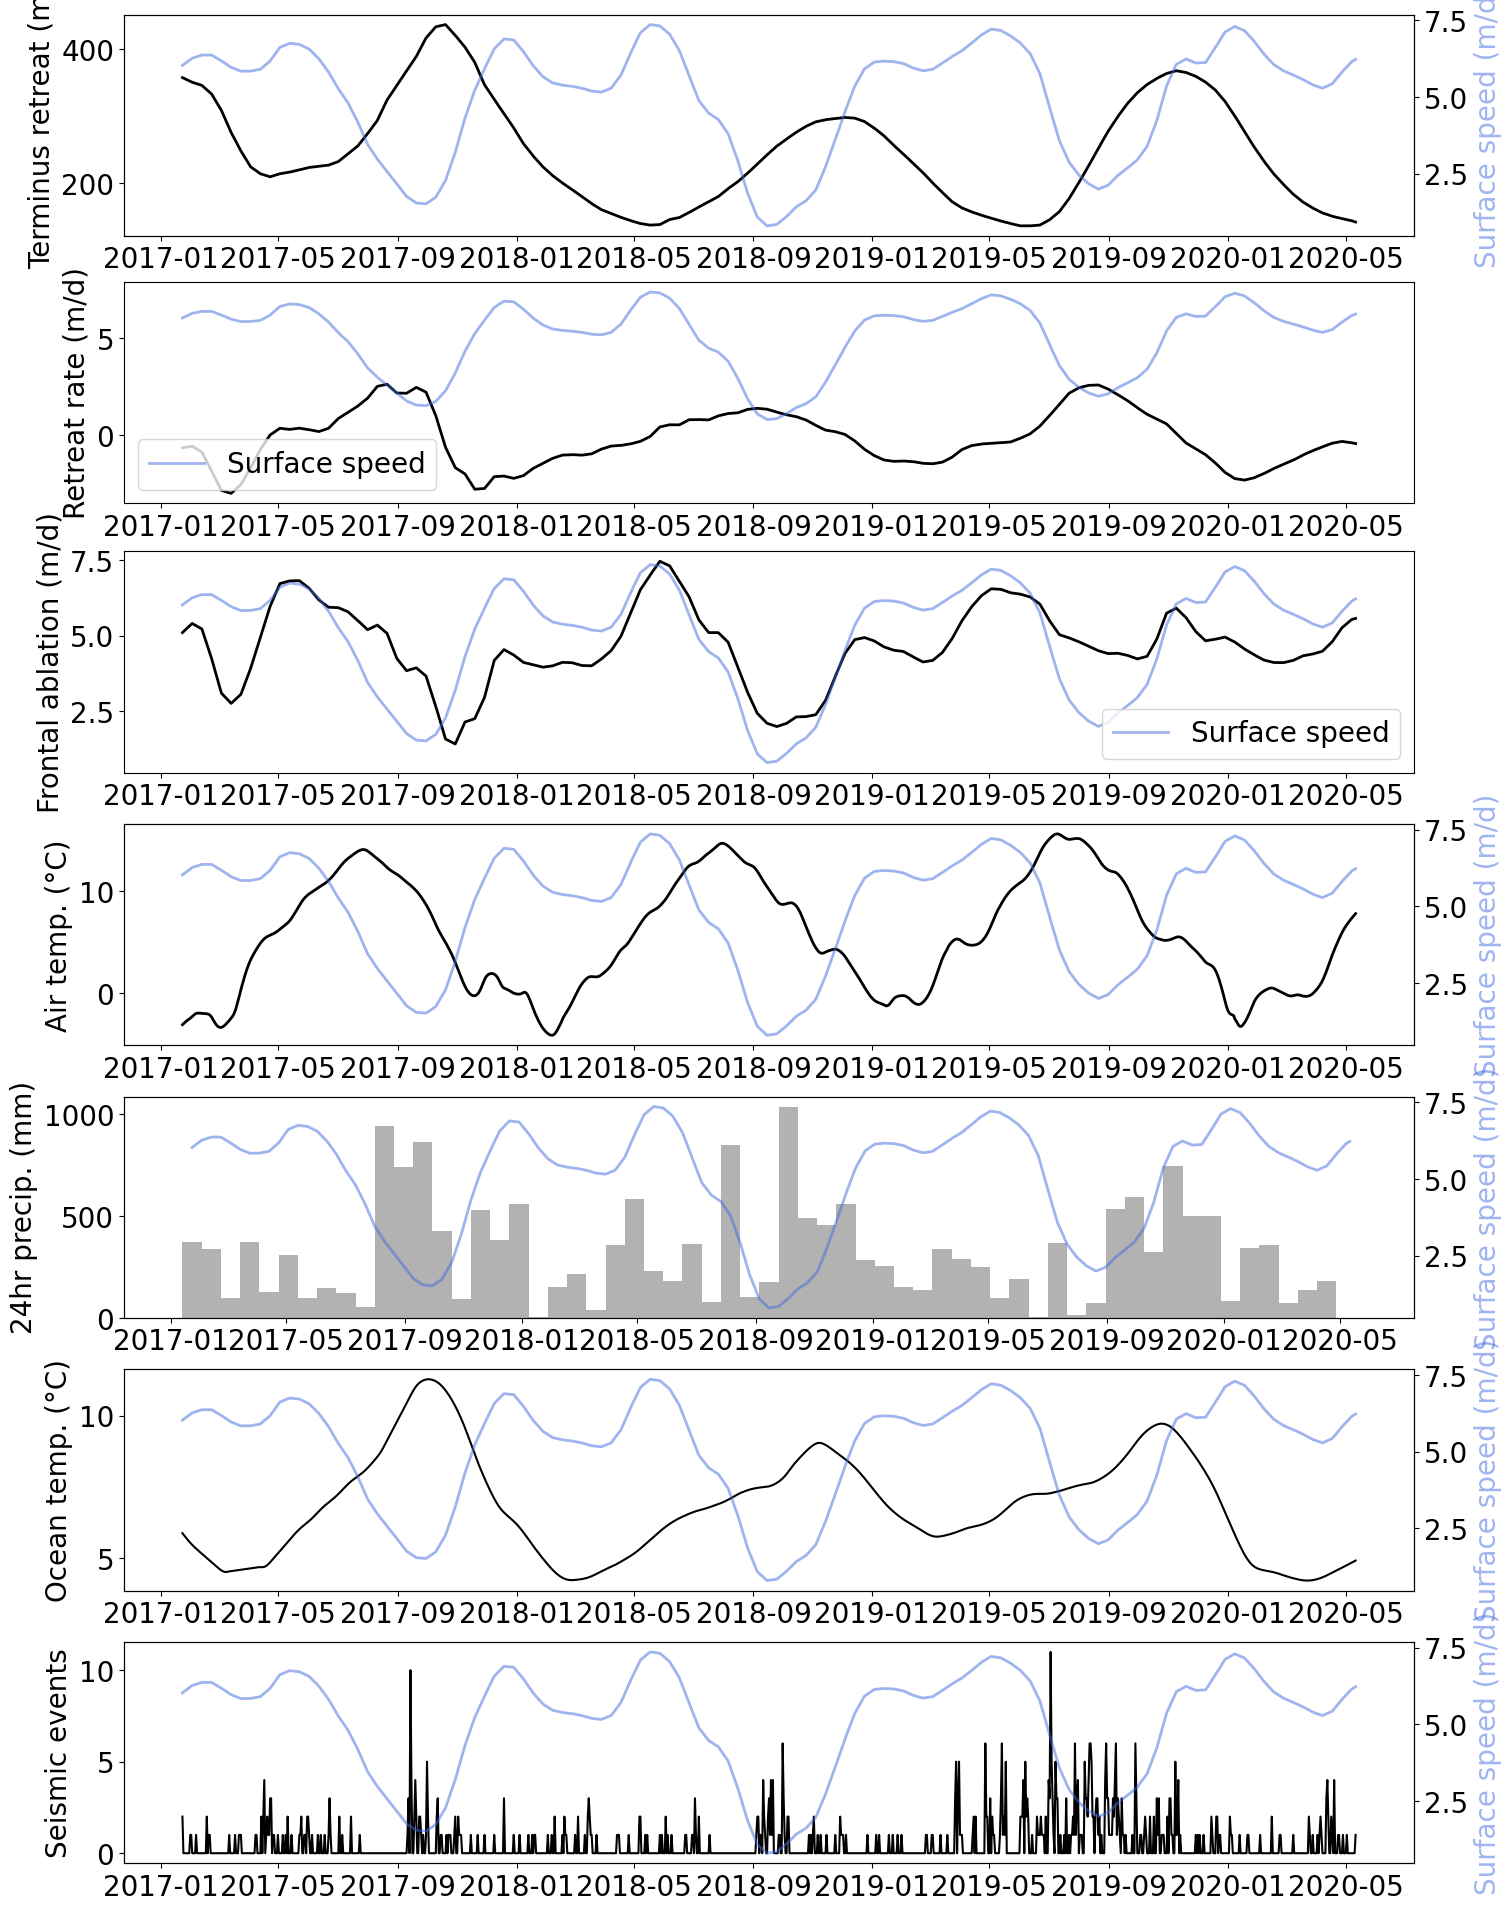

In [74]:
# resample precipitation data
dt_resample = 20
df_sum = df_save.resample(str(dt_resample)+"d", on="Date").mean().interpolate()

def plot_vel(axi):
    secax = axi.twinx()
    secax.plot(df_save["Date"], df_save.surface_speed_m_per_yr / 365, color="royalblue", lw=2, alpha=0.5)
    secax.set_ylabel("Surface speed (m/d)", color="royalblue", alpha=0.5)



fs = 20
plt.rc('font', size=fs)


fig, ax = plt.subplots(7,1, layout='constrained', figsize=(15,19))

# terminus position
i = 0
ax[i].plot(df_save["Date"], df_save.terminus_advance_m, color="black", lw=2)
ax[i].set_ylabel("Terminus retreat (m)")
plot_vel(ax[i])

# retreat rate
i = 1
ax[i].plot(df_save["Date"], df_save.retreat_rate_m_per_yr / 365, color="black", lw=2)
ax[i].set_ylabel("Retreat rate (m/d)")
ax[i].plot(df_save["Date"], df_save.surface_speed_m_per_yr / 365, color="royalblue", lw=2, alpha=0.5, label="Surface speed")
ax[i].legend()

# frontal ablation
i = 2
ax[i].plot(df_save["Date"], df_save.frontal_ablation_m_per_yr / 365, color="black", lw=2)
ax[i].set_ylabel("Frontal ablation (m/d)")
ax[i].plot(df_save["Date"], df_save.surface_speed_m_per_yr / 365, color="royalblue", lw=2, alpha=0.5, label="Surface speed")
ax[i].legend()

# air temperature
i = 3
ax[i].plot(df_save["Date"], df_save.AirTempC_Yakutat_smooth, color="black", lw=2)
ax[i].set_ylabel("Air temp. (°C)")
plot_vel(ax[i])

# precipitation
i = 4
ax[i].bar(df_sum.index, df_sum.Precip_Yakutat_24h_mm*1000, width=dt.timedelta(days=dt_resample), color="black", linewidth=0, alpha=0.3)
ax[i].set_ylabel("24hr precip. (mm)")
plot_vel(ax[i])

i = 5
ax[i].plot(df_save["Date"], df_save["OceanTemp@50m_degC"], color="black")
ax[i].set_ylabel("Ocean temp. (°C)")
plot_vel(ax[i])

i = 6
ax[i].plot(df_save["Date"], df_save["evid"], color="black")
ax[i].set_ylabel("Seismic events")
plot_vel(ax[i])
fig.savefig("six-years-timeseries.jpg")

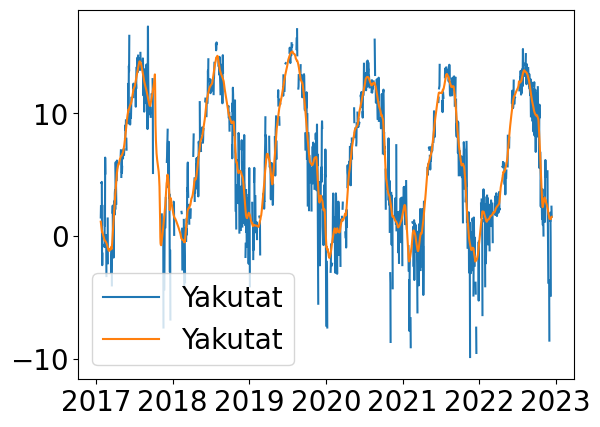

In [13]:
plt.plot(df_all.Date,df_all.AirTempC_Yakutat,label="Yakutat")
plt.plot(df_all.Date,df_all.AirTempC_Yakutat_smooth,label="Yakutat")
# plt.plot(df_all.Date,df_all.AirTempC_Haenke1,label="Haenke1")
# plt.plot(df_all.Date,df_all.AirTempC_Haenke2,label="Haenke2")
plt.legend()

In [18]:
# make sure the end of the time series stops at the day of the year it starts (otherwise there are jumps in computing means over different years if days in e.g. January have less samples than in May)
end_year      = df_all.Date.iloc[-1].year
start_date    = df_all.Date.iloc[77].date()
end_date      = start_date.replace(year=end_year)
id_full_years = np.where((df_all.Date >= pd.Timestamp(start_date)) & (df_all.Date < pd.Timestamp(end_date)) & (df_all.Date != pd.Timestamp(2020, 2, 29)))  # removing leap day of 2020, makes sure there is the same amount of days in all of the years
df_full_years = df_all.iloc[id_full_years[0],:]
df_full_years.reset_index(inplace=True)

# check that there is the same amount of days for each day of the year
tind    = np.array([di.timetuple().tm_yday for di in df_full_years["Date"] ])
id_mv   = np.where((df_full_years.Date >= pd.Timestamp(2020,3,1)) & (df_full_years.Date <= pd.Timestamp(2020,12,31)))   # move all days of year after leap day one day forward
tind[id_mv] -= 1

for d in range(np.min(tind), np.max(tind)+1):
    assert np.sum(np.array(tind) == d) == end_year - start_date.year

df_full_years

,index,Date,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,velocity,terminus,ablation,retreat_rate
0,77,2017-04-10,4.438380,4.230056,4.650794,5.341926,4.562366,4.136559,6.147078,0.003556,4.562366,4.136559,6.147078,5.140381,2147.885473,217.279026,1693.146476,-375.306870
1,78,2017-04-11,4.442954,4.228642,4.665452,5.350841,4.227174,3.771739,5.578523,0.002032,4.227174,3.771739,5.578523,5.246661,2150.060208,216.250831,1730.529104,-340.277749
2,79,2017-04-12,4.447529,4.227229,4.680110,5.359755,5.468817,5.092473,NaN,NaN,5.468817,5.092473,NaN,5.427104,2152.234943,215.222636,1767.911732,-305.248627
3,80,2017-04-13,4.513431,4.286372,4.688037,5.349535,9.278022,9.004396,NaN,NaN,9.278022,9.004396,NaN,5.539193,2154.409678,214.194440,1805.294360,-270.219505
4,81,2017-04-14,4.579882,4.345449,4.694903,5.338703,8.115217,7.764130,NaN,NaN,8.115217,7.764130,NaN,5.632319,2164.373958,213.741981,1842.944358,-243.171170
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,1898,2022-04-05,3.921562,4.101023,4.469594,5.194104,1.372632,0.782105,2.459077,0.011684,1.372632,0.782105,2.459077,2.589864,2158.317110,52.951589,2044.168168,-39.827994
1821,1899,2022-04-06,3.943254,4.123305,4.502415,5.218074,1.248810,0.645238,3.516871,0.006604,1.248810,0.645238,3.516871,2.620913,2159.863390,52.969788,2041.599808,-43.415349
1822,1900,2022-04-07,3.965159,4.146205,4.538747,5.245264,6.060714,5.659524,3.593189,0.007366,6.060714,5.659524,3.593189,2.682171,2161.409670,52.987986,2039.031448,-47.002705
1823,1901,2022-04-08,3.988619,4.170666,4.578667,5.274567,0.998958,0.402083,2.120228,0.019812,0.998958,0.402083,2.120228,2.809573,2167.959606,52.712239,2038.444439,-54.230698


In [20]:
def unique(x):
    return list(set(x))

# average over the year
ti_start_date = start_date.timetuple().tm_yday -1
strt_date = dt.date(start_date.year, 1, 1)
df_avyr = pd.DataFrame()
for col in df_full_years:
    if col == "Date":
        continue
    vls = []
    for dd in range(np.min(tind), np.max(tind)+1):
        val = np.mean(df_full_years[col][np.where(np.array(tind) == dd)[0]])
        vls.append(val)
    if df_avyr.empty:
        ds = []
        for doy in np.sort(unique(tind)):
            if doy <= ti_start_date:
                ds.append(strt_date.replace(year=strt_date.year+1)  + dt.timedelta(days=int(doy) - 1))
            else:
                ds.append(strt_date + dt.timedelta(days=int(doy) - 1))
        df_avyr["Date"] = ds
    df_avyr[col] = vls
df_avyr.sort_values(by="Date", inplace=True)
df_avyr.Date = pd.to_datetime(df_avyr.Date)   # otherwise Date is not in the correct format for .resample
df_avyr

,Date,index,Temperature [deg C] @ 25m,Temperature [deg C] @ 50m,Temperature [deg C] @ 100m,Temperature [deg C] @ 150m,AirTempC_Haenke1,AirTempC_Haenke2,AirTempC_Yakutat,Precip_Yakutat,PDD_Haenke1,PDD_Haenke2,PDD_Yakutat,AirTempC_Yakutat_smooth,velocity,terminus,ablation,retreat_rate
99,2017-04-10,807.4,4.711143,4.709278,5.007833,5.575145,4.023320,3.567767,3.044747,0.002388,4.023320,3.567767,4.004331,3.665968,2112.048506,156.401978,1807.896065,-226.946465
100,2017-04-11,808.4,4.727424,4.717620,4.995889,5.578847,3.744050,3.285799,3.695742,0.001524,3.744050,3.285799,4.617200,3.761885,2120.842128,155.792568,1827.287471,-216.355523
101,2017-04-12,809.4,4.744045,4.726857,4.981929,5.582194,3.836354,3.369247,3.636807,0.011684,3.836354,3.369247,3.636807,3.894721,2129.635749,155.183158,1846.678877,-205.764582
102,2017-04-13,810.4,4.775547,4.751142,4.974734,5.583453,4.890411,4.451890,3.828877,0.018965,4.890411,4.451890,3.828877,4.022150,2139.173866,154.572506,1865.991560,-196.174198
103,2017-04-14,811.4,4.808255,4.777139,4.975482,5.585108,4.896268,4.437107,4.376797,0.012192,4.896268,4.437107,4.376797,4.141639,2150.401228,154.098283,1884.621589,-189.079849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,2018-04-05,1167.6,4.539631,4.632117,5.031987,5.527724,1.932930,1.403485,2.042418,0.010245,1.932930,1.403485,2.042418,2.870856,2082.590197,125.629111,1826.006982,-180.731118
95,2018-04-06,1168.6,4.554262,4.646383,5.033448,5.537850,2.979059,2.450211,3.321462,0.003619,2.979059,2.450211,3.321462,2.920396,2087.214470,125.189733,1834.379596,-176.844502
96,2018-04-07,1169.6,4.571021,4.661563,5.029923,5.547772,3.870769,3.394950,1.648330,0.002984,4.023373,3.682971,2.509269,2.988556,2091.838743,124.750354,1842.752210,-172.957886
97,2018-04-08,1170.6,4.589997,4.677500,5.023023,5.556806,2.676891,2.136175,3.253320,0.012446,2.677672,2.301279,3.253320,3.097220,2099.345983,124.296162,1853.125896,-169.901465


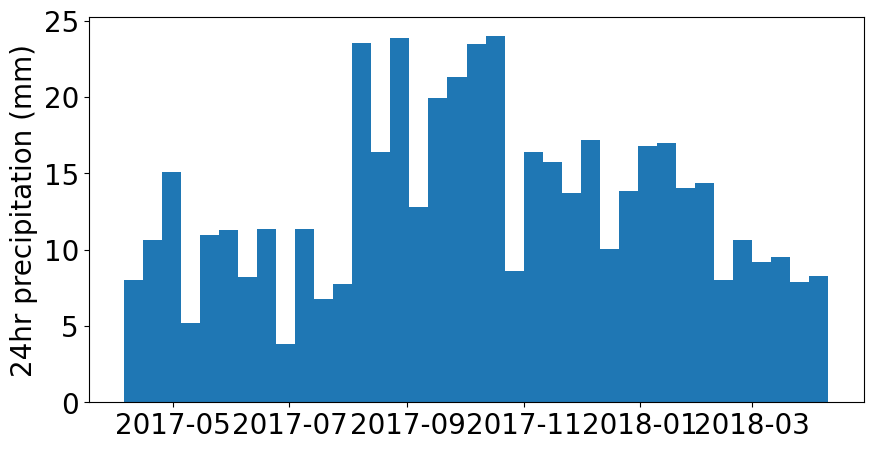

In [21]:
# resample precipitation data
dt_resample = 10
plt.figure(figsize=(10,5))
ax = plt.subplot(111)
df_sum = df_avyr.resample(str(dt_resample)+"d", on="Date").mean().interpolate()
ax.bar(df_sum.index, df_sum.Precip_Yakutat*1000, width=dt.timedelta(days=dt_resample), linewidth=0)
ax.set_ylabel("24hr precipitation (mm)")
ax.xaxis_date()

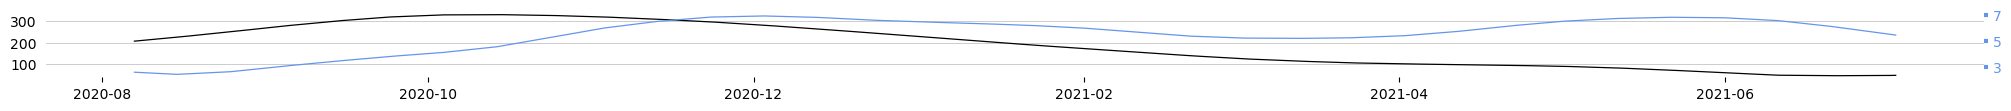

In [22]:
# poster plot
yr0   = pd.Timestamp(2020,8,7)
yrend = pd.Timestamp(2021,7,3)
id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date <= yrend))[0]

lw = 0.9
fs = 10
plt.rc('font', size=fs)

fig, ax = plt.subplots(1, constrained_layout=True, figsize=(20,1.0))
ax.plot(df_full_years.Date[id_yr], df_full_years["terminus"][id_yr], color="black", lw=lw)
ax.grid(axis="y", lw=0.45)
# ax.set_ylabel("Terminus retreat (m)", labelpad=35)

ax.set_aspect(0.04)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.tick_params(axis='y', which='major', width=0)
plt.tick_params(axis='x', which='major') #, labelsize=0, labelcolor='white')

secax = ax.twinx()
secax.grid(False)
secax.plot(df_full_years.Date[id_yr], df_full_years["velocity"][id_yr] / 365, color="cornflowerblue", lw=lw)
secax.spines['top'].set_visible(False)
secax.spines['right'].set_visible(False)
secax.spines['bottom'].set_visible(False)
secax.spines['left'].set_visible(False)
secax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2,4,6,8,10,12]))
plt.tick_params(axis='y', colors='cornflowerblue', which='major', width=3, length=3)
# secax.set_ylabel("Speed (m/d)", color="cornflowerblue", labelpad=35)
secax.set_yticks([3,5,7])

fig.savefig("long_plot.svg", dpi=1630, transparent=True)

In [114]:
0.04 * 18

0.72

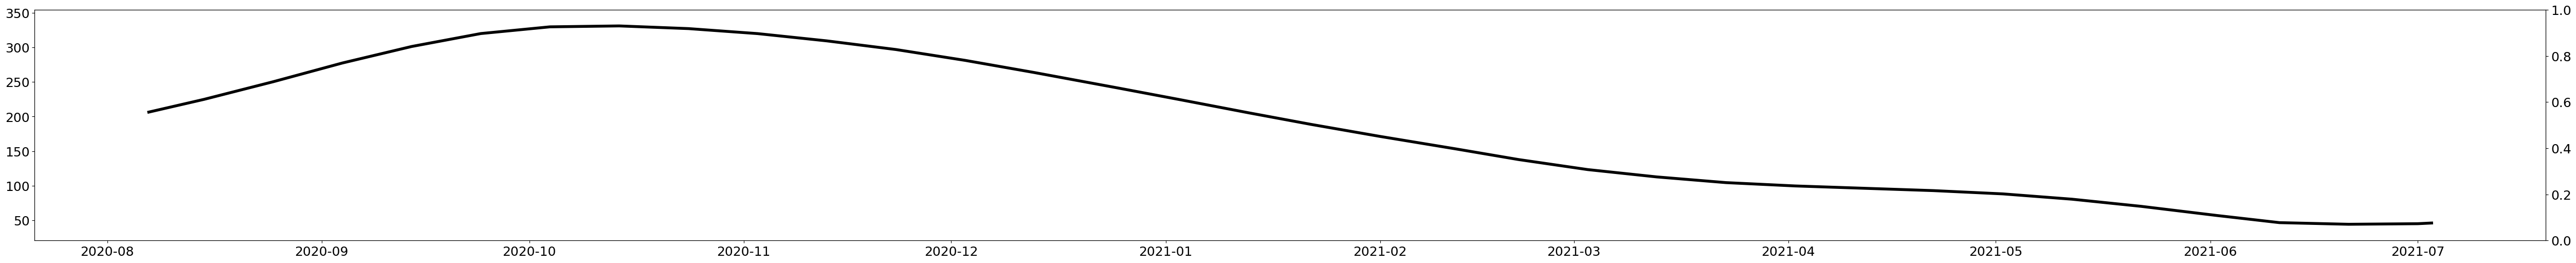

In [37]:
fig, ax = plt.subplots(1, constrained_layout=True, figsize=(50,5))
ax.plot(df_full_years.Date[id_yr], df_full_years["terminus"][id_yr], color="black", lw=4)
ax.set_aspect(0.1)
secax = ax.twinx()

In [21]:
df_full_years.Date[id_yr]

1214   2020-08-07
1215   2020-08-08
1216   2020-08-09
1217   2020-08-10
1218   2020-08-11
          ...    
1540   2021-06-29
1541   2021-06-30
1542   2021-07-01
1543   2021-07-02
1544   2021-07-03
Name: Date, Length: 331, dtype: datetime64[ns]

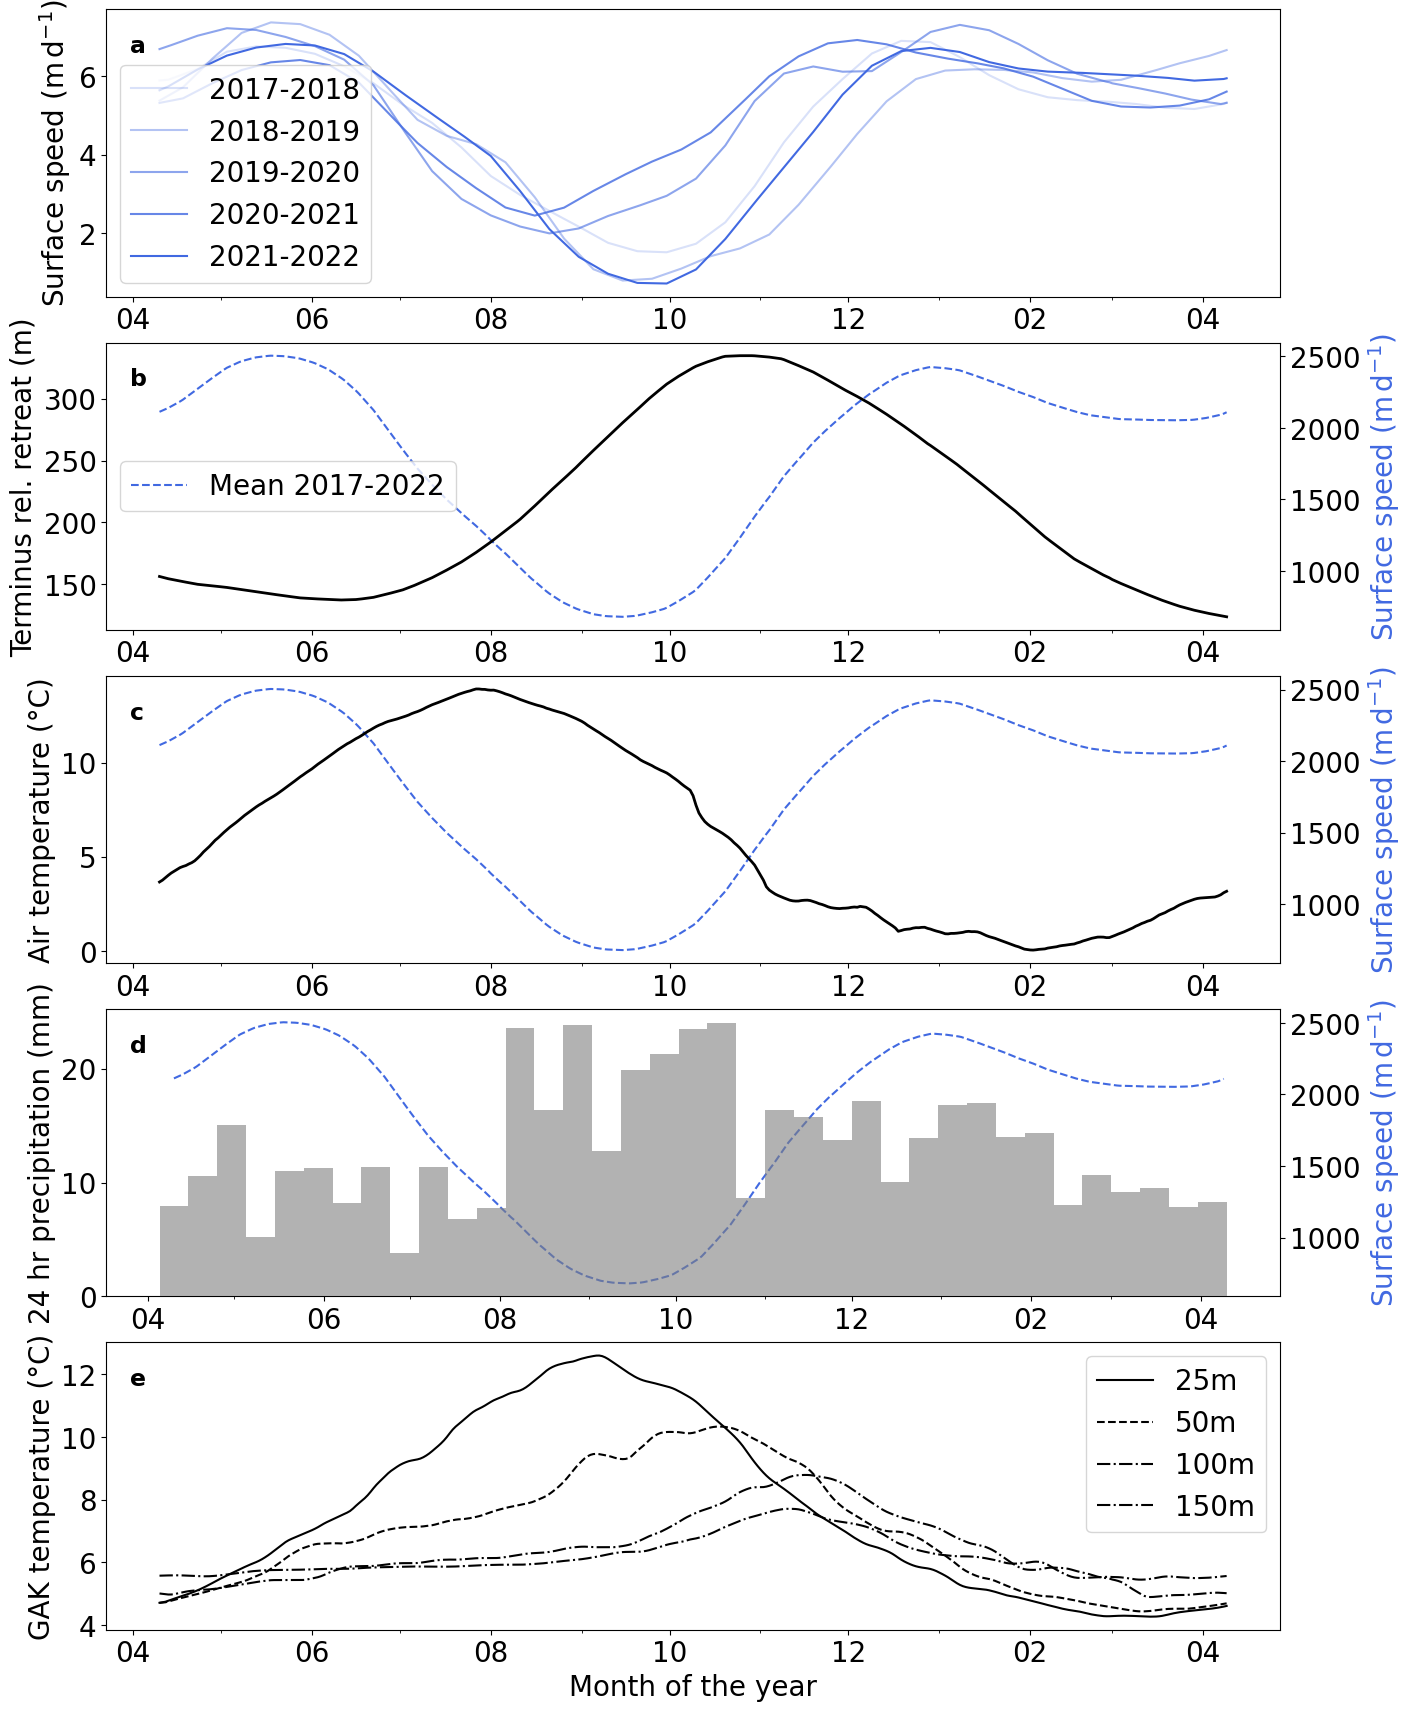

In [32]:
fs = 20
plt.rc('font', size=fs)

def format_ax(ax, panel, plot_vel=True, draw_legend=False):
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[2,4,6,8,10,12]))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m'))
    if plot_vel:
        secax = ax.twinx()
        secax.plot(df_avyr["Date"], df_avyr["velocity"], color="royalblue", linestyle="--", label="Mean 2017-2022")
        secax.set_ylabel(r"Surface speed ($\mathrm{m\,d^{-1}}$)", color="royalblue")
        ax.set_zorder(secax.get_zorder()+1)
        ax.set_frame_on(False)                      # see https://matplotlib.org/stable/gallery/text_labels_and_annotations/date.html
        if draw_legend:
            secax.legend(loc="center left")
    ax.annotate(panel, (0.02,0.85), xycoords='axes fraction', fontweight='bold', fontsize=fs-3)

# can replace df_avyr by df_all to only average over sections and not year
fig, ax = plt.subplots(5,1, layout='constrained', figsize=(14,17))

# velocity
i = 0
alphas = [0.2, 0.4, 0.6, 0.8, 1.0]
for ii in range(1, 6):
    yr0 = pd.Timestamp(start_date) + pd.Timedelta(days=365*(ii-1))
    yrend = pd.Timestamp(start_date) + pd.Timedelta(days=365*ii)
    if yrend.year == 2020:                       # if there is a leap day, pd.Timedelta will take this into account, but we want to ignore it
        yrend = yrend + pd.Timedelta(days=1)
    id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date < yrend))[0]
    ax[i].plot(df_avyr.Date, df_full_years["velocity"][id_yr] / 365, color="royalblue", alpha=alphas[ii-1], label=str(yr0.year)+"-"+str(yr0.year+1))
    ax[i].set_ylabel(r"Surface speed ($\mathrm{m\,d^{-1}}$)")
    ax[i].legend()
format_ax(ax[i], "a", plot_vel=False)

# Terminus position
i = 1
ax[i].plot(df_avyr["Date"], df_avyr.terminus, color="black", lw=2); ax[i].set_ylabel("Terminus rel. retreat (m)")
format_ax(ax[i], "b", draw_legend=True)

# Air temperature
i = 2
ax[i].plot(df_avyr["Date"], df_avyr.AirTempC_Yakutat_smooth, color="black", lw=2); ax[i].set_ylabel("Air temperature (°C)")
format_ax(ax[i], "c")

# Precipitation
i = 3
ax[i].bar(df_sum.index, df_sum.Precip_Yakutat *1000, width=dt.timedelta(days=dt_resample), color="grey", alpha=0.6, linewidth=0); ax[i].set_ylabel("24 hr precipitation (mm)")
format_ax(ax[i], "d")

# GAK temperatures
i = -1
stls = ["-", "--", "-.", "-.", "."]
for (n,col) in enumerate(df_all.filter(like="Temperature [deg C] @", axis=1)):
    ax[i].plot(df_avyr["Date"], df_avyr[col], stls[n], label=col.split(" ")[-1], color="black"); ax[i].set_ylabel("GAK temperature (°C)")
    ax[i].legend()
    ax[i].set_xlabel("Month of the year")
format_ax(ax[i], "e", False)

fig.savefig("four-panel-yearly.jpg")

Text(0.1, 0.9, 'b')

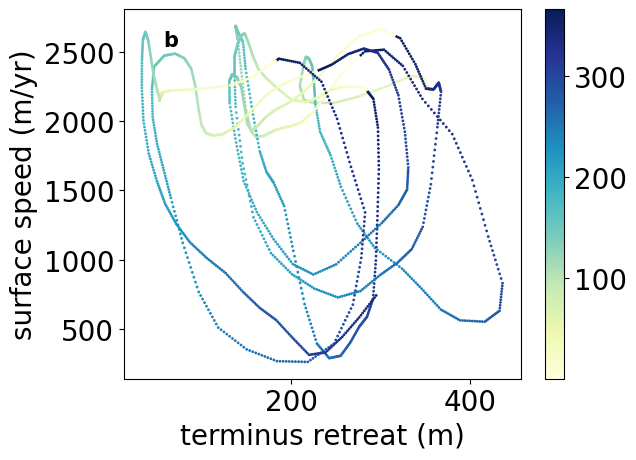

In [24]:
d_ofyear    =  [di.timetuple().tm_yday for di in df_all["Date"] ]   # day of the year
plt.scatter(df_all.terminus, df_all.velocity, 1, d_ofyear, cmap="YlGnBu")
plt.xlabel("terminus retreat (m)")
plt.ylabel("surface speed (m/yr)")
plt.colorbar()
plt.annotate("b", (0.1,0.9), xycoords='axes fraction', fontweight='bold', fontsize=15)

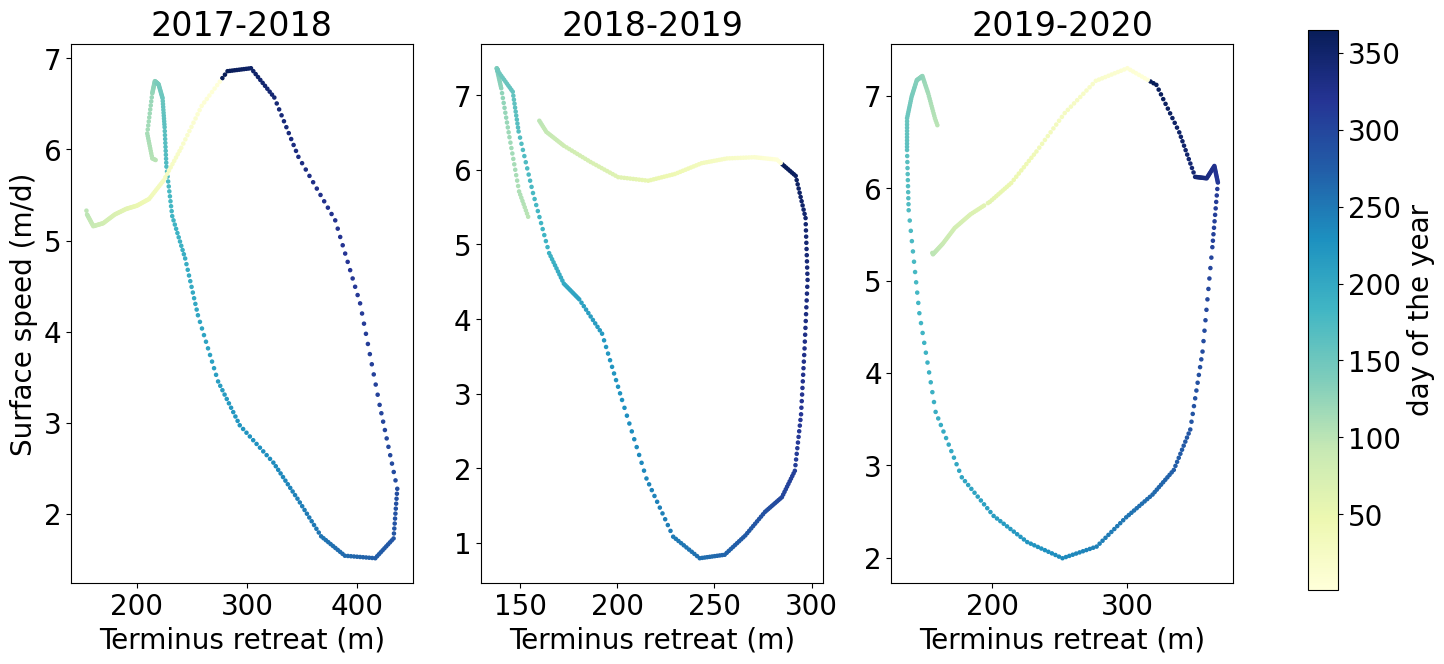

In [25]:
fig, ax = plt.subplots(1,3, figsize=(15,7)) #, sharex=True, sharey=True)
cax = fig.add_axes([0.95, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_full_years["Date"] ])   # day of the year
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_full_years.Date >= yr0) & (df_full_years.Date < pd.Timestamp(start_date) + pd.Timedelta(days=365*ii)))[0]
    im = ax[ii-1].scatter(df_full_years.terminus[id_yr], df_full_years["velocity"][id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("Terminus retreat (m)")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")

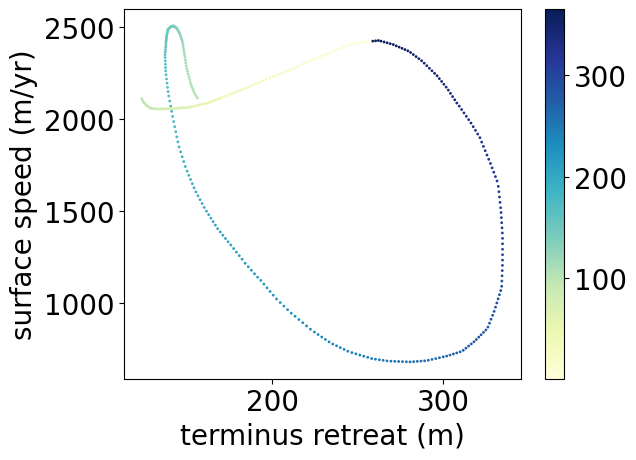

In [26]:
d_ofyear    =  [di.timetuple().tm_yday for di in df_avyr["Date"] ]   # day of the year
plt.scatter(df_avyr.terminus, df_avyr.velocity, 1, d_ofyear, cmap="YlGnBu") # cmap="twilight"
plt.xlabel("terminus retreat (m)")
plt.ylabel("surface speed (m/yr)")
plt.colorbar()

/tmp/ipykernel_1673962/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_1673962/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_1673962/2047856609.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always

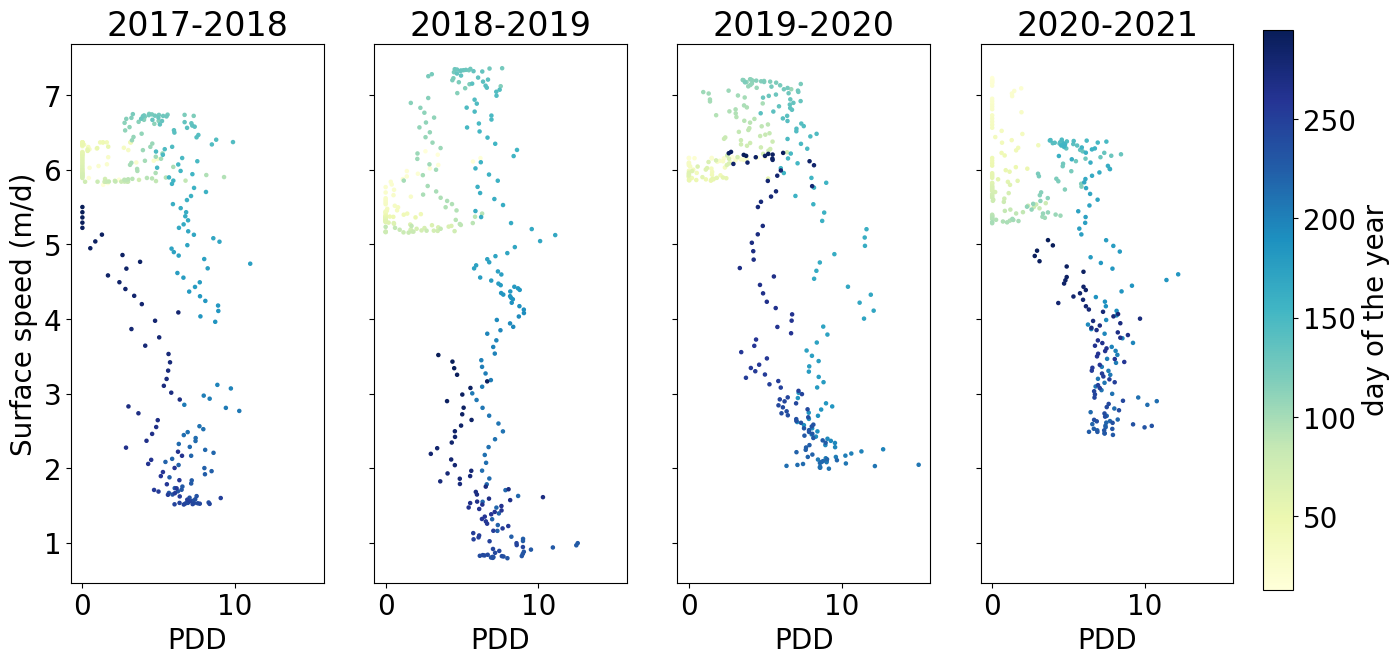

In [27]:
# scatter plot PDD vs velocity
df_veloc0, df_weather0 = equal_period([df_veloc,df_weather])
# df_veloc0 = df_veloc0.resample("2d").mean().interpolate()
# df_weather0 = df_weather0.resample("2d").mean().interpolate()
start_date0    = df_veloc0.index[0].date()

df_weather0
dt_overlap = -50

fig, ax = plt.subplots(1,4, figsize=(15,7), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_veloc0.index ])   # day of the year
for ii in range(1, 5):
    yr0 = pd.Timestamp(start_date0) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_veloc0.index >= yr0) & (df_veloc0.index < pd.Timestamp(start_date0) + pd.Timedelta(days=365*ii+dt_overlap)))[0]
    im = ax[ii-1].scatter(df_weather0.PDD_Haenke1[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("PDD")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")
# fig.savefig("veloc_cumPDD_scatter.jpg")
fig.savefig("veloc_PDD_scatter.jpg")

/tmp/ipykernel_1673962/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_1673962/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
/tmp/ipykernel_1673962/1949334714.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will al

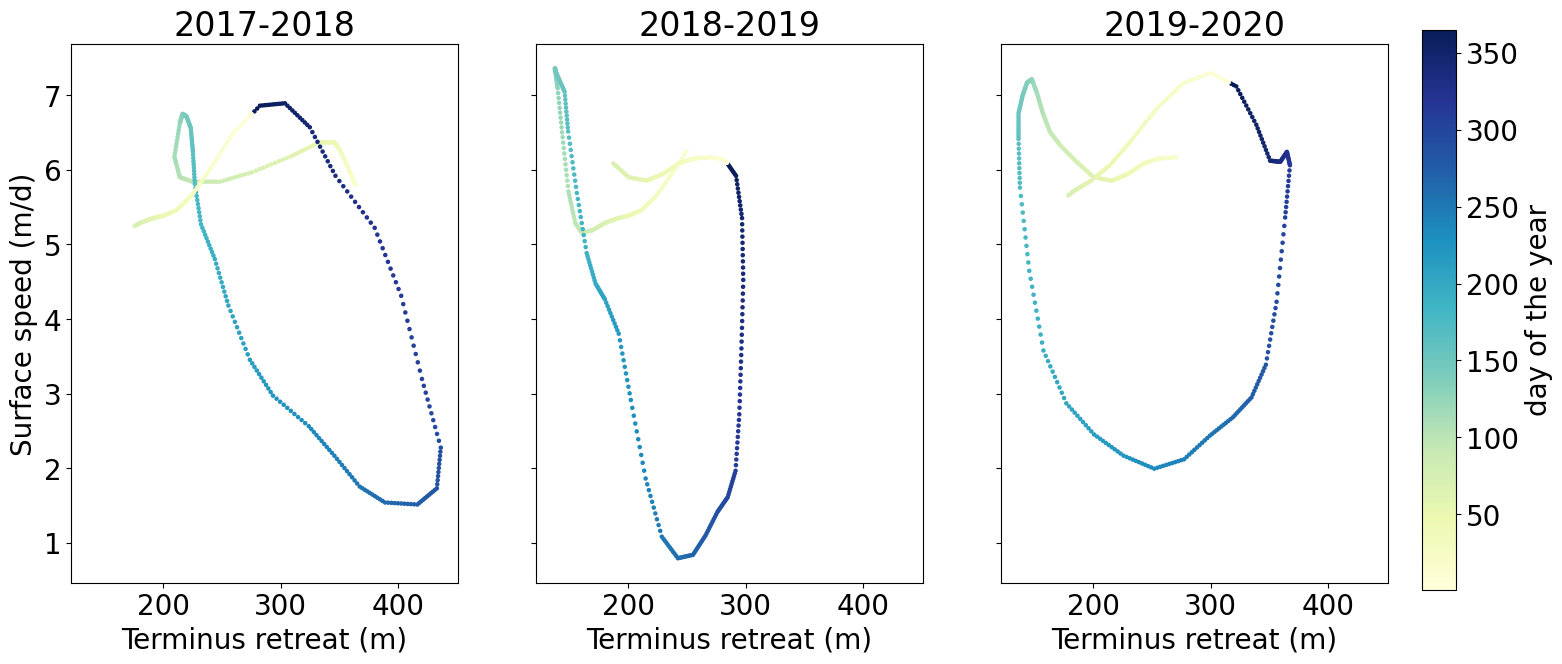

In [28]:
# scatter plot terminus vs velocity
df_veloc0, df_terminus0 = equal_period([df_veloc,df_terminus])
start_date0    = df_veloc0.index[0].date()

dt_overlap = 60

fig, ax = plt.subplots(1,3, figsize=(17,7), sharex=True, sharey=True)
cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
d_ofyear    =  np.array([di.timetuple().tm_yday for di in df_veloc0.index ])   # day of the year
for ii in range(1, 4):
    yr0 = pd.Timestamp(start_date0) + pd.Timedelta(days=365*(ii-1))
    id_yr = np.where((df_veloc0.index >= yr0) & (df_veloc0.index < pd.Timestamp(start_date0) + pd.Timedelta(days=365*ii+dt_overlap)))[0]
    im = ax[ii-1].scatter(df_terminus0.mean(axis=1)[id_yr], df_veloc0.mean(axis=1)[id_yr] / 365, 5, d_ofyear[id_yr], cmap="YlGnBu") # cmap="twilight"
    ax[ii-1].set_xlabel("Terminus retreat (m)")
    ax[ii-1].set_title(str(yr0.year)+"-"+str(yr0.year+1))
ax[0].set_ylabel("Surface speed (m/d)")
fig.colorbar(im, cax=cax, orientation='vertical',label="day of the year")
fig.savefig("veloc_terminus_scatter.jpg")